# Image pre-processing
When we think about the challenges of optical character recognition (OCR) of rare materials, we often think about the difficulty of training a language model to recognize archaic letterforms or to handle the inherent variability of hand-set type.

Those are serious questions, for sure, but it turns out that one of the biggest determinants of OCR quality is the quality of the images that we attempt to run OCR on.

OCR tends to work best on the images that look the worst to us. In one-bit black-and-white images, each pixel is either black or white, which makes the "decision" about a letterform's shape simpler for the OCR software. The best OCR language model in the world will have trouble producing good output if the images have too much "noise" in them confounding the recognition of letterforms. The software will attempt to recognize anything that it takes to be text, so images that present features that can be mistaken for text will produce garbled output, even if the OCR training is a good one.

This all means that the pre-processing of images *before* they're OCR'ed can be at least as important as having a good OCR training.

This notebook and the following one walk through pre-processing steps to prepare images in hopes of getting the best result we can from our OCR training.

The first part of the notebook allows us to experiment with the effects of potentially small adjustments to the "threshold" parameter used in preparing derivative black and white images.

While we *could* binarize the images we're working with as-is, we'll see in this notebook why that probably wouldn't be a good idea.

After experimenting with thresholding, we'll work to crop the images to exclude portions of the page that don't include text.

In the next notebook, we'll work to straighten  any skewing in the images so that the lines of text are more readily recognized by the OCR software. In that notebook we'll also convert the images to black and white so that we can experiment with performing OCR on them.

>*Note:* Your attention **really** doesn't need to be on the details of the code, itself, in these notebooks. As it turns out, most of the code in this notebook ends up being devoted not to performing the transformations we're actually after, but simply to showing the stages of the transformation in the browser.
>
> In the first part of the notebook, focus on the different variables that affect the way that the images are transformed. I've set the notebook up so that you can change variables easily and re-process images to see what difference your changes make.
>
>In the second, longer, part of the notebook, focus on the strategies and heuristics involved in identifying the text block, even if the details of the code seem obscure.


## Before you start: Getting today's images
The collection of images we are using today is too large to push to GitHub, so you'll need to retrieve them from the shared Google Drive folder that Rare Book School created for the class.

Visit Google Drive in your web browser and click "Shared with me" in the navigation bar at the left.

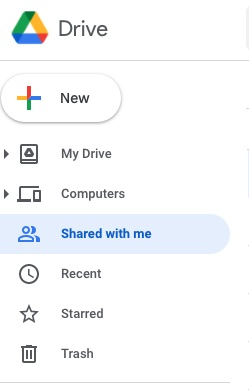

Right-click on `L-100 Digital Approaches to Bibliography & Book History-2023`, then select "Add shortcut to Drive."

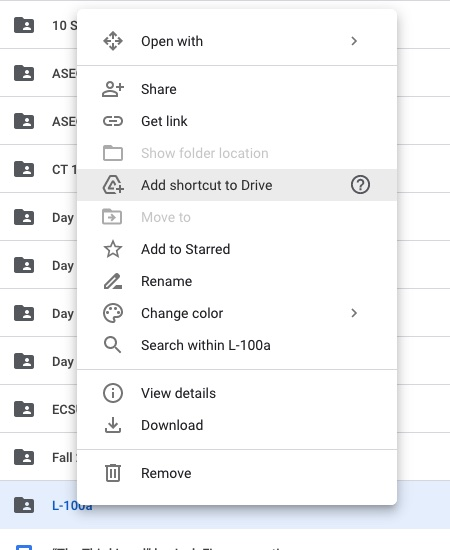

Click "Add Shortcut." The `L-100 Digital Approaches to Bibliography & Book History-2023` folder will now be available when we mount Google Drive in Colaboratory.
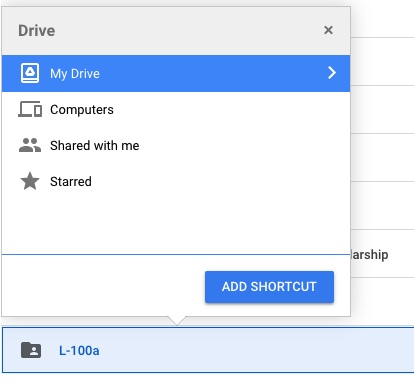

###A - Move images from Google Drive to Colaboratory environment
We won't use all of the images for this notebook, but we'll copy them into Colab, anyway. (If you want to play around with additional images, they'll be available to you.

In [ ]:
#Code cell #1
#Connect to Google Drive
from google.colab import drive
drive.mount('/gdrive')

#Import libraries to allow interactive widgets in this notebook
import ipywidgets as widgets
from ipywidgets import interact, interact_manual, interactive

In [ ]:
#Code cell #2
%cp /gdrive/MyDrive/L-100\ Digital\ Approaches\ to\ Bibliography\ \&\ Book\ History-2023/2023_page_images.zip /content/2023_page_images.zip
%cd /content/
!unzip 2023_page_images.zip
%cd /content/2023_page_images/
%ls -al

### B - Setting our source image
We'll use pages from scans of copies of James Thomson's *Sophonisba* in UVA's Small Special Collections Library (PR3732.T7 1730f, PR3732.T7 1730g, and PR3732.T7 1730j).

In [ ]:
#@title Select an image
 #@markdown Run this cell to create a select list widget that allows us to choose an image to process. With an image selected (a default is provided), you can continue working through the code below.

 #@markdown You only need to run this cell once (re-running it will just set things back to the default value). But you can change the image you're working with using the select list in order to see how these processes work given different starting images.
import os
import glob
file_list = sorted([os.path.basename(file) for file in glob.glob('/content/2023_page_images/*')])
image_select = widgets.Dropdown(
    description='Choose image',\
    options = file_list,\
    value = '1730f_p13.tif',
    style={'description_width': 'initial'})
display(image_select)

In [ ]:
#Code cell #3
source_directory = '/content/2023_page_images/'
source_image = source_directory + image_select.value

## 1 - Getting the idea of binarizing: Setting a threshold manually
While the pixels in color images have several different values (for red, green, and blue channels), each pixel in a black and white image is either black or white: black and white images are "binary" in the sense that every pixel has either one or the other of two values.

When we convert a color image to black and white, we have to have some way of deciding which pixels are going to be white and which are going to be black. This involves setting a cut-off point, or threshold: everything above a certain value will get turned to black, and everything below that value will get turned to white.

Differences in threshold value can have a *dramatic* effect on the resulting images; and those differences can, in turn, have a dramatic effect on the quality of OCR output. The first thing we're going to do is play around with changing threshold values manually to get a sense of how large a role this parameter plays in the quality of our images.

We're going to start by using the `Pillow` library, a Python 3 fork of the original `PIL` ("Python Image Library").

`Pillow` can do lots of useful things with images (we'll only be scratching the surface), and you can find lots of tutorials online for using it. (Note that `Pillow` is installed by default in Google Colaboratory. If you were working in a different environment, you'd need to install Pillow using `pip`.)

In [ ]:
#Code cell #4
# !pip install pillow
#Install the Image and ImageDraw libraries from PIL (actually Pillow)
from PIL import Image, ImageDraw

### 1.a - Converting from color to grayscale
We'll start by converting our color image to grayscale as an intermediate step towards getting our image to true black and white—a "binary" file in which each pixel is either black or white. We'll use [`PIL`'s `convert()` method](https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.Image.convert), which requires us to select a mode for conversion. We'll use `L` for grayscale. (`PIL`'s various modes are [explained in the documentation](https://pillow.readthedocs.io/en/stable/handbook/concepts.html#concept-modes).)

In [ ]:
#Code cell #5
#Use the open() method of Pillow's Image library to open the .tif file
pilcolor_image = Image.open(source_image)

#Use the Image library's convert() method to convert the color image to grayscale
pilgray_image = pilcolor_image.convert('L')

#Output
pilgray_image

### 1.b - Converting our grayscale image to black and white
Since converting from color to grayscale was as simple as selecting the mode `L`, let's try converting our grayscale image to binary by selecting mode `1`: "1-bit pixels, black and white, stored with one pixel per byte."

In [ ]:
#Code cell #6
pilbw_image = pilgray_image.convert('1')
pilbw_image

#### 1.b.i - Overriding the default behavior: turning off dithering
Okay, that's not ideal. As noted in [the documentation](https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.Image.convert):
>The default method of converting a greyscale (“L”) or “RGB” image into a bilevel (mode “1”) image uses Floyd-Steinberg dither to approximate the original image luminosity levels. If dither is NONE, all values larger than 127 are set to 255 (white), all other values to 0 (black). To use other thresholds, use the point() method.

Let's try that again, this time turning off the default dithering behavior: this time any pixel above (i.e., darker than) a threshold value of 127 will be turned to black and any pixel below that threshold will be turned to white.

In [ ]:
#Code cell #7
pilbw_image = pilgray_image.convert('1', dither=0)
pilbw_image

#### 1.b.ii - Adjusting the threshold point manually
That's better. In this case, the default threshold of 127 seems pretty good, though some of the text looks kind of eroded. Given how variable the inking can be in early print, this default value might not always work. Let's see what happens if we adjust the threshold point.

Be sure to run the next cell to bring up a text box that will allow you to change the threshold value, then try experimenting with different threshold values.


In [ ]:
 #@title Set a threshold value {display-mode: "form"}
 #@markdown Run this cell, then enter a value between 0 and 255 and hit the "enter" key to adjust the threshold point for our image in the cell below. (We begin with a default of 150)

 #@markdown You only need to run this cell once (re-running it will just set things back to the default value). Try entering a new value and then re-running the *next* cell a few times to see the difference that different threshold values make.
 thresh_value_int = widgets.BoundedIntText(
    value=150,
    min=0,
    max=255,
    step=1,
    description='Threshold:',
    disabled=False
)
 display(thresh_value_int)

In [ ]:
#Code cell #8
#See https://stackoverflow.com/questions/9506841/using-python-pil-to-turn-a-rgb-image-into-a-pure-black-and-white-image/50090612#50090612

#Get the current value of our slider widget from the cell above
thresh = thresh_value_int.value

#This is defining a kind of quickie function 'fn' that will be used at line 18
#This is going to look at every pixel of our image. If the value of that pixel is
#greater than our "thresh" value (set by the slider above), then set the pixel to
#255 (pure black). If the pixel value is less than "thresh," set the pixel to 0
#(pure white)
fn = lambda x : 255 if x > thresh else 0

#Convert our image, this time overriding the default dithering behavior
#with the threshold we've chosen, using the lambda function from line 11
pilbinary_image = pilgray_image.convert('L').point(fn, mode='1')

pilbinary_image

It shouldn't take much experimenting to see that different threshold points can create very different results. But let's say we have 1,000 page images from 50 different books. Given the variability of early print, there may not be one perfect threshold value that gets the best results for all of our images: what would be great for one image might leave another one too dark and noisy, and might leave a third too faint.

## Interlude - Automating image optimization

What we need is a way to determining a good threshold value for each image without having to experiment on each image individually. Fortunately, this is a problem that people have worked on. While we might be able out how to implement, say [Otsu's method](https://en.wikipedia.org/wiki/Otsu%27s_method) in code ourselves, we'd probably be better off taking advantage of the fact that other people have already done that work. For this, we'll turn from PIL to a different library.

OpenCV is a computer vision library that can be used for all sorts of things, including feature detection, image classification, and more. A library like this one might seem to be overkill for simply converting images from color to black and white, but it offers us lots of things built-in that would be difficult to work out from scratch, ourselves.

(Note that OpenCV and the Python wrapper for it are installed by default in Google Colab. If you were working in a different environment, you'd first need to install OpenCV—the process differs depending on your operating system, so I won't go into that here. You'd also need to install the Python wrapper using `pip`.)

###We are immediately going to run into a problem...
The aim here is to let the computer determine the best threshold level for us—and eventually we'll be able to do that. But the images from UVA's Special Collections present a challenge we're going to have to deal with first.

Let's see what happens if we try to binarize our image using Otsu's method.
>*Note:* Opening and converting images with OpenCV is more or less like opening and converting images with PIL, but you'll notice a few differences. We use `cv2.imread()` and `cv2.cvtColor` rather than `Image.open()` and `Image.convert`, for example, and, in addition to supplying the file to open and convert, we also have to indicate a method related to the color space we need to work in. We're working with a Python wrapper for OpenCV, but OpenCV, itself, is written in C++, so some of the conventions around capitalization and so forth will look different from lots of Python code you'll see. Don't worry about understanding any of this code at the moment: we'll circle back to it later. Right now, let's just see the problematic output we're going to get from these images.

In [ ]:
#Code cell #9
# !pip install opencv-python
import cv2
#This is a Google Colab-specific patch to enable us to view OpenCV images
#in the browser
from google.colab.patches import cv2_imshow
#Other Python libraries that CV2 needs
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
#Code cell 10
#Open the original color image
cv2color_image = cv2.imread(source_image, cv2.IMREAD_COLOR)
#Convert to grayscale
cv2gray_image = cv2.cvtColor(cv2color_image, cv2.COLOR_BGR2GRAY)
#Apply Gaussian blur
cv2blurred_image = cv2.GaussianBlur(cv2gray_image, (5, 5), 0)
#Threshold using Otsu's method
(T_orig, cv2binary_otsu_image) = cv2.threshold(cv2blurred_image, 0, 255, cv2.THRESH_OTSU)
#Show binarized image
cv2_imshow(cv2binary_otsu_image)
print('Otsu threshold value: ' + str(T_orig))

"Wait," I can almost hear you say, "shouldn't computing an optimal threshold level make the image look... better?"

Notice how low a threshold value Otsu's method produces here. I'm pretty sure this is getting skewed by the dark black border around the page: there's way more black in the image *as a whole* than there is in the portino of the image we're actually interested in.

UVA Special collections does not crop its page images to contain just the text block: the image extends beyond the boundaries of the page, and also includes some of the facing page. This is probably a good practice, in that it ensures that someone looking at the images gets a sense of what the entire page looks like.

But it's clearly causing a problem here. For purposes of binarizing the page images for OCR, it seems desirable to crop the page images closer to the text block. We could certainly do that using image editing software like Photoshop, but we can also use OpenCV to detect the portion of the page we're interested in and produce cropped versions of these images: we can get rid of both the black border and the portion of the facing page that's visible (which would cause problems of its own if we were to try to OCR these images).

From here on out in this notebook, we have a new mission: cropping the images to isolate the text block. In the next notebook, we'll

##2 - Cropping pages
Buckle up, because here's where things start to get weird.

As people who appreciate books, we tend to value photographs of books that look close to what we know the books would look like if we had them on a table in front of us. But the computer doesn't "see" these images the way we do, and making the images work well for the computer can involve making them look *worse* to us.

These next cells walk through a process for identifying the text block in the page image and creating a cropped derivative image for OCR. We're going to do this by:

1. Inverting the black-on-white image to white-on-black;
2. "Dilating" the white pixels until they run together with one another, forming (more or less) continuous blocks where the ink is on the page;
3. Finding the contour(s) of the white block(s) and then determining which one(s) is/are centered more or less in line with the middle of the page (judging left to right);
4. Determining the size and position of rectangle(s) that would form a boundary to contain the contour(s) we're interested in keeping;
5. Determining the size and position of a rectangle that would contain all of the smaller rectangles we identified around text regions: this should give us a fair approximation of the text block.


>*Note:* I should say right now that OpenCV is a very large library, and I can't claim to have great mastery of all its different methods. I suspect there's probably a more efficient (and more elegant) way to accomplish what I'm doing here, but this process seems to work for a variety of page images in the UVA copies of *Sophonisba*: other things I tried worked well for some pages, but fell down on others.

####2.a - Invert the image
The first step is to transform our black-on-white image to white-on-black.

In [ ]:
#Code cell 11
#This sets anything above a threshold level to true black, and combines two types
#of thresholding (THRESH_BINARY_ENV and the OpenCV implementation of Otsu's method).
thresh = cv2.threshold(cv2blurred_image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
cv2_imshow(thresh)

In [ ]:
#@title Set kernel size for dilation {display-mode: "form"}

#@markdown Run the code in this cell to create a set of
#@markdown slider widgets for changing the values of the
#@markdown "kernel" used to dilate the white pixels in the
#@markdown image. You can change the height and width of the
#@markdown kernel (i.e., the amount of vertical and horizontal
#@markdown dilation to be applied) as well as the number of
#@markdown iterations (how many times the dilation operation
#@markdown will be applied.)

#@markdown You only need to run this cell once (re-running
#@markdown it will just re-set the values to their defaults).
#@markdown You can change the values of the sliders and
#@markdown then run Code cell 12 to see the different
#@markdown effects that different values have.
kernel_width = widgets.IntSlider(description = 'Kernel width', \
                                               min=1, max=25, step=1, value=10)
kernel_height = widgets.IntSlider(description='Kernel height', \
                                                 min=1, max=25, step=1, value=20)
num_iterations = widgets.IntSlider(description='Iterations', min=1, \
                      max=10, step=1, value=5)
display(kernel_width)
display(kernel_height)
display(num_iterations)

####2.b - Dilate the inverted image
This cell dilates the white pixels of the inverted image using the kernel shape defined by our sliders.

In [ ]:
#Code cell 12
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_width.value, kernel_height.value))
#We dilate the pixels using the shape defined by kernel, and perform the operation
#five times. Try changing the shape of the kernel and increasing or decreasing
#the number of iterations to see how the output changes.
dilate = cv2.dilate(thresh, kernel, iterations=num_iterations.value)
cv2_imshow(dilate)

###2.c - Identify contours of dilated regions
This identifies the outlines of the regions that appear in the image. We are only interested in the external contours—we're not looking for contours of regions that might appear inside other contours. And we're okay with

In [ ]:
#Code cell 13
#Identify the contours and their hierarchy
contours, hierarchy = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

#These lines are just to visualize what we have. We make a copy of the dilate
#image, converting it from binary to color (so we can see colored lines on it),
#then draw all of the contours on that new image in green.
show_contours = cv2.cvtColor(dilate.copy(), cv2.COLOR_BayerGR2RGB)
show_contours = cv2.drawContours(show_contours, contours, -1, (0,255,0), 3)
cv2_imshow(show_contours)

###2.d - Defining contours of interest
I'm not entirely confident that I've found the best approach here, but let me explain my reasoning for what I'm doing at this step.

Some of these detected contours are actually not useful for us: we *don't* want the white band around three sides of the image, for instance, and we also don't want the blocks of white that show the text that was visible on the facing page.

This section offers one approach to figuring out what parts of the page are most likely to be of interest.

####2.d.i - Define a region in the center of the page
It seems to me that the centers of most of the contours we're interested fall in a zone more or less in the center of the page. (Not all of them, but most of them.) Code cell 14 defines a zone one-quarter the width of the image, centered on the image's vertical midline (that is, it finds the middle of the image's x-axis, then figures out an x-value one-eighth of the width of the image to the left of the midline, and another x-value one-eighth of the width to the right of the midline).

Code cell 14 just defines the x-axis values for the `middle_zone` and shows where the area of interest is.

In [ ]:
#Code cell 14
#Get the height and width of the image
height = np.shape(dilate)[0]
width = np.shape(dilate)[1]

#Divide the width by 8
eighth = int(width/8)
#Find the midpoint on the x-axis
midpoint_x = int(width/2)
#Create a tuple with the left-most and right-most x-axis for this zone
middle_zone = (midpoint_x - eighth, midpoint_x + eighth)

#This code is just to display what's going on. We make a copy of the image
#that already has our contours drawn in green...
show_middle_zone = show_contours.copy()
#...then draw two blue lines to show the edges of the middle zone
show_middle_zone = cv2.line(show_middle_zone, (middle_zone[0],0),
                            (middle_zone[0], height), (255,0,0), 3)
show_middle_zone = cv2.line(show_middle_zone, (middle_zone[1],0),
                            (middle_zone[1],height), (255,0,0), 3)
cv2_imshow(show_middle_zone)

####2.d.ii - Identify contours centered on the area of interest
Code cell 15 looks at each of the contours and determines where its center is. If the x-axis coordinate of the contour's center falls within the `middle_zone`, we add it it to a list of `middle_zone_contours`.

In [ ]:
#Code cell 15
#Create an empty list
middle_zone_contours = []
#Iterate through the list of contours
for contour in contours :
  #I do not begin to understand the Math behind this, but this calculates
  #the centroid of an area of pixels defined by the contour.
  #https://learnopencv.com/find-center-of-blob-centroid-using-opencv-cpp-python/
  M = cv2.moments(contour)
  contour_x = int(M["m10"] / M["m00"])
  #If the x-axis value of the centroid is greater than or equal to the smaller
  #x-axis value of the middle_zone and less than or equal to the larger
  #x-axis value of the middle_zone, then add it to the list of middle_zone_contours
  if middle_zone[0] <= contour_x <= middle_zone[1] :
    middle_zone_contours.append(contour)

#This code just shows what we've done
#We make a copy of the image that already had the contours drawn in green and the
#middle_zone boundaries drawn in blue
show_middle_contours = show_middle_zone.copy()

#Iterate through the list of middle_zone_contours, outlining them in purple
for middle_contour in middle_zone_contours :
  show_middle_contours = cv2.drawContours(show_middle_contours, [middle_contour], -1, (255, 0, 255), 3)
cv2_imshow(show_middle_contours)

####2.d.iii - Find boundary rectangles for contours of interest
As we can see, not all of the text regions had their centroids within the `middle_zone`, but we're eventually going to define a rectangle that should take them in, too.

First, we get the boundary rectangles for each of the `middle_zone_contours`: this is a rectangle that can completely contain the irregular shape of the contour.

In [ ]:
#Code cell 16

#The image is getting a little busy, so I'm making a new copy of the dilate image,
#converting it to color to be able to show colored lines and rectangles
show_rectangles = cv2.cvtColor(dilate.copy(), cv2.COLOR_BayerGR2BGR)
#Put the detected contours back on the image
for contour in contours :
  #All contours in green
  show_rectangles = cv2.drawContours(show_rectangles, contour, -1, (0,255,0), 3)
for middle_zone_contour in middle_zone_contours :
  #Middle zone contours in purple
  show_rectangles = cv2.drawContours(show_rectangles, [middle_zone_contour], -1, (255, 0, 255), 3)

#Create a list of rectangles founding by getting the boundingRect of each contour
#in the middle_zone
rectangles = [cv2.boundingRect(contour) for contour in middle_zone_contours]
for rectangle in rectangles :

  #openCV stores boundingRects as a tuple consisting of the x, y coordinate of
  #the upper left corner, the width of the rectangle, and the height of the rectangle.
  #But it *draws* rectangles based on two points: the upper left corner and
  #the lower right corner. So these lines figure out those two points for each
  #rectangle
  start_point = (rectangle[0], rectangle[1])
  end_point = (rectangle[0] + rectangle[2], rectangle[1] + rectangle[3])
  #Then draw the rectangle on the image
  show_rectangles = cv2.rectangle(show_rectangles, start_point, end_point, (0, 0, 255), 3)
  #And print the coordinates of the upper left corner
  show_rectangles = cv2.putText(show_rectangles, str(rectangle[0]) + ',' + str(rectangle[1]),
                              (rectangle[0], rectangle[1]),
                              cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 255), 2)

cv2_imshow(show_rectangles)




####2.d.iv - Determine a rectangle large enough to contain all of the boundary rectangles of the contours of interest
By themselves, the red rectangles on the image above don't take in all of the text on the page. But if we drew a rectangle whose left side was as far left as the left side of left-most rectangle on the page; whose top side was as high as the top side of the top-most rectangle on the page; whose right side was as far right as the right side of the right-most rectangle on the page; and whose bottom side was as far down as the bottom side of the bottom-most rectangle on the page, it would pretty well take in all of the text on the page.

Code cell 17 figures out the coordinates we'd need for that imaginary rectangle, and code cell 18 draws that rectangle.

I suspect there's a better way to do this, but this is what occurred to me:

1. Make four lists of coordinate values:

  a.  The x-axis coordinate of each rectangle's left side;
  b. The x-axis coordinate of each rectangle's right side;
  c. The y-axis coordinate of each rectangle's top side;
  d. The y-axis coordinate of each rectangle's bottom side.
  
2. Get the leftmost and rightmost x-axis coordinates and the topmost and bottom-most y-axis coordinates from those lists.

3. Construct coordinates for the four corners of an imaginary rectangle using those minima and maxima.

In [ ]:
#Code cell 17
#Construct lists of x- and y-axis coordinates for each rectangle

#The x-axis coordinate of the upper left corner (and hence the left side of the
#rectangle)  is the first value in the boundingRect tuple
leftx_coords = [rectangle[0] for rectangle in rectangles]

#The x-axis coordinate of the right side of the rectangle can be gotten by
#adding the width of the rectangle (the third item in the boundingRect tuple)
#to the x-axis coordinate of the upper-left corner
rightx_coords = [rectangle[0] + rectangle[2] for rectangle in rectangles]

#The y-axis coordinate for the upper left corner (and hence the top side of the
#rectangle) is the second value in the boundingRect tuple
topy_coords = [rectangle[1] for rectangle in rectangles]

#The y-axis coordinate for the bottom side of the rectangle can be gotten by
#adding the height of the rectangle (the fourth item in the boundingRect tuple)
#to the y-axis coordinate of the upper left corner
bottomy_coords = [rectangle[1]  + rectangle[3] for rectangle in rectangles]

#Get the left-, right-, top-, and bottom-most x- and y-axis values by getting,
#variously, the minima and maxima of the values in the lists we just made, then
#padding them a little bit so that we're not cropping right against the text
leftmost = min(leftx_coords) - 100
rightmost = max(rightx_coords) + 100
topmost = min(topy_coords) - 50
bottommost = max(bottomy_coords) + 50

#Construct coordinates for the four corners of the imaginary rectangle using the
#left-, right-, top-, and bottom-most x- and y-axis values
upper_left = (leftmost, topmost)
upper_right = (rightmost, topmost)
lower_right = (rightmost, bottommost)
lower_left = (leftmost, bottommost)

In [ ]:
#Code cell 18
#Make a copy of the show_rectangles image with the red rectangles already drawn
text_block = show_rectangles.copy()
#Draw a rectangle on the image, using the upper_left and lower_right coordinates
text_block = cv2.rectangle(text_block, upper_left, lower_right, (255, 255, 0), 3)

cv2_imshow(text_block)


####2.d.v - Use imaginary rectangle to crop the original image to the text block
It can be hard to remember as we step through the code, but all of these strange-looking white-on-black images are actually representations of our original page image.

That means that we can take information derived from these reader-hostile (but computer-friendly) images and apply it to the original image.

Code cell 19 uses the x- and y-axis values of the imaginary rectangle we drew in code cell 18 to crop a region of the original color image.

In [ ]:
#Code cell 19
text_block_cropped = cv2color_image.copy()
y = topmost
x = leftmost
w = rightmost
h = bottommost
text_block_cropped = text_block_cropped[y:h, x:w]
cv2_imshow(text_block_cropped)

###2.e - Automatically cropping images
We've been stepping through the process for identifying the text block very gradually, which makes it look very laborious. (The fact that we've been visualizing each step along the way dramatically increases the amount of code we've had to wade through.)

Now that we've worked out a method for doing it, though, we can write a single function to take in all of these steps and process a folder full of images with a simple `for` loop.

In [ ]:
#Code cell 20
def get_text_block(image) :
  #Invert
  thresh = cv2.threshold(cv2blurred_image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
  #Dilate
  kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (10, 20))
  dilate = cv2.dilate(thresh, kernel, iterations=5)
  #Find_all_contours
  contours, hierarchy = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  #Define middle-of-page area of interest
  height = np.shape(dilate)[0]
  width = np.shape(dilate)[1]
  eighth = int(width/8)
  midpoint_x = int(width/2)
  middle_zone = (midpoint_x - eighth, midpoint_x + eighth)
  #Select contours centered on area of interest
  middle_zone_contours = []
  for contour in contours :
    M = cv2.moments(contour)
    contour_x = int(M["m10"] / M["m00"])
    if middle_zone[0] <= contour_x <= middle_zone[1] :
      middle_zone_contours.append(contour)
  #Get bounding rectangles
  rectangles = [cv2.boundingRect(contour) for contour in middle_zone_contours]
  #Construct text block rectangle
  leftx_coords = [rectangle[0] for rectangle in rectangles]
  rightx_coords = [rectangle[0] + rectangle[2] for rectangle in rectangles]
  topy_coords = [rectangle[1] for rectangle in rectangles]
  bottomy_coords = [rectangle[1]  + rectangle[3] for rectangle in rectangles]
  leftmost = min(leftx_coords) - 100
  rightmost = max(rightx_coords) + 100
  topmost = min(topy_coords) - 50
  bottommost = max(bottomy_coords) + 50
  return image[topmost:bottommost, leftmost:rightmost]


In [ ]:
#Code cell 21
if not os.path.exists('/content/cropped/') :
  os.makedirs('/content/cropped/')
for file in glob.glob('/content/2023_page_images/*.tif') :
  basename = os.path.basename(file)[:-4] + '-cropped.tif'
  original = cv2.imread(file, cv2.IMREAD_COLOR)
  cropped = get_text_block(original)
  cv2.imwrite('/content/cropped/' + basename, cropped)
  print('Saved ' + basename)

We've saved these files to the Colab environment, but we need to move them over to Google Drive so they're available for use in the next notebook.

We'll compress the files into a .zip archive, then move them over to Google Drive.

In [ ]:
#Code cell 21
%cd /content/
!zip -r cropped.zip cropped/
!mv /content/cropped.zip /gdrive/MyDrive/rbs_digital_approaches_2023/output/cropped.zip